In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.metrics import r2_score, median_absolute_error,mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_log_error

In [3]:
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [4]:
from tqdm import tqdm_notebook
from itertools import product

In [5]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred)/y_true)*100

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv("./MSFT.csv",index_col=['Date'], parse_dates=['Date'])
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-19,67.500000,68.099998,67.430000,67.690002,64.718475,26961100
2017-05-22,67.889999,68.500000,67.500000,68.449997,65.445099,16237600
2017-05-23,68.720001,68.750000,68.379997,68.680000,65.665009,15425800
2017-05-24,68.870003,68.879997,68.449997,68.769997,65.751060,14593900
2017-05-25,68.970001,69.879997,68.910004,69.620003,66.563751,21854100
2017-05-26,69.800003,70.220001,69.519997,69.959999,66.888802,19827900
2017-05-30,69.790001,70.410004,69.769997,70.410004,67.319077,17072800
2017-05-31,70.529999,70.739998,69.809998,69.839996,66.774078,30436400
2017-06-01,70.239998,70.610001,69.449997,70.099998,67.022667,21603600


In [8]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
drop_cols = ['Volume','Adj Close','Low','High','Open']
df.drop(drop_cols,axis=1,inplace=True)
df.head(5)

,Close
Date,
2017-05-19,67.690002
2017-05-22,68.449997
2017-05-23,68.680000
2017-05-24,68.769997
2017-05-25,69.620003


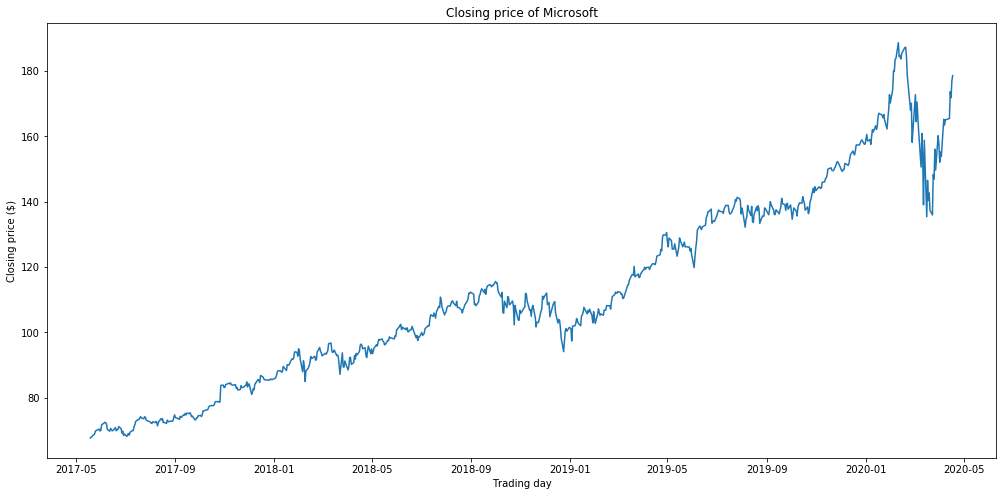

In [11]:
#Exploratory data analysis
plt.figure(figsize=(17,8))
plt.plot(df.Close)
plt.title('Closing price of Microsoft')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

In [12]:
#Moving Average
def plot_moving_average(series,window,plot_intervals=False,scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(17,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean,'g',label = 'Roling mean trend')
    
    #plot confidence interval for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:],rolling_mean[window:])
        deviation = np.std(series[window:]-rolling_mean[window:])
        lower_bound = rolling_mean - (mae+scale*deviation)
        upper_bound = rolling_mean + (mae+scale*deviation)
        
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
    
    plt.plot(series[window:],label = "Actual values")
    plt.legend(loc='best')
    plt.grid(True)

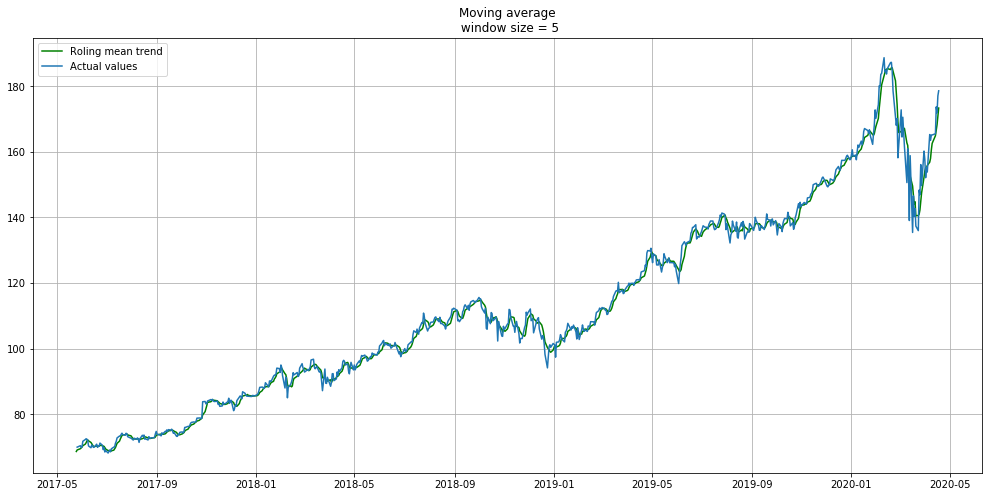

In [13]:
#smoothing by the prvious 5 days
plot_moving_average(df.Close,5)

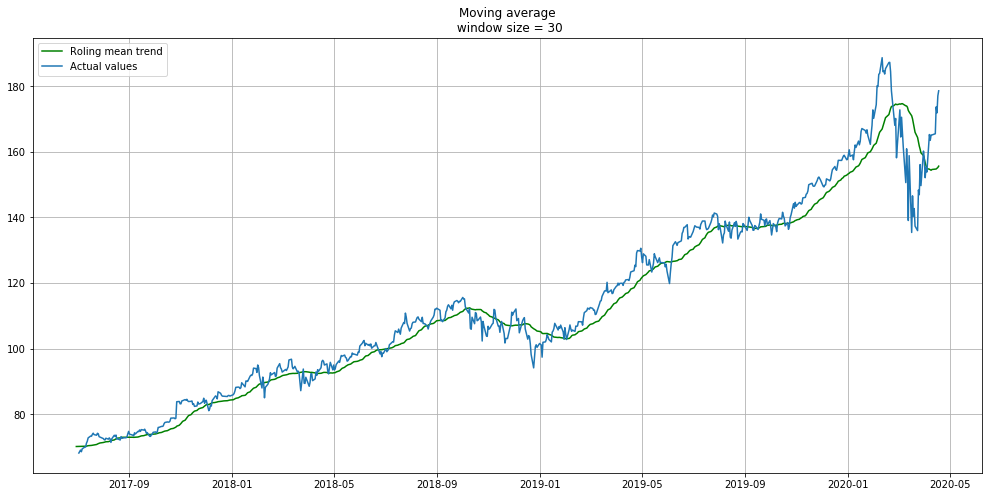

In [14]:
#Smooth by the previous month (30 days)
plot_moving_average(df.Close, 30)

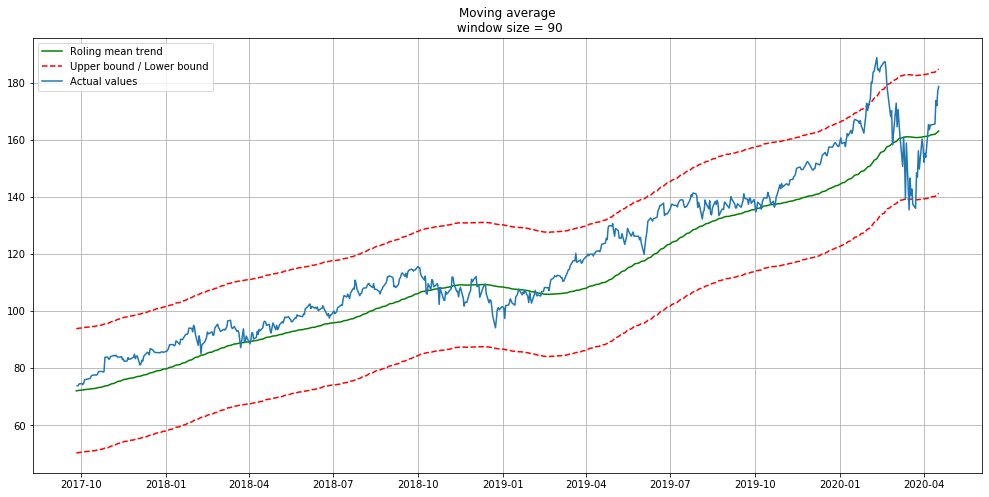

In [15]:
#Smooth by previous quarter (90 days)
plot_moving_average(df.Close, 90, plot_intervals=True)

In [16]:
#Exponential smoothing
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1,len(series)):
        result.append(alpha*series[n]+(1-alpha)*result[n-1])
    return result

In [17]:
def plot_exponential_smoothing(series,alphas):
    plt.figure(figsize=(17,8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series,alpha),label='Alpha {}'.format(alpha))
    plt.plot(series.values,'c',label ='Actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('Exponential Smoothing')
    plt.grid(True)

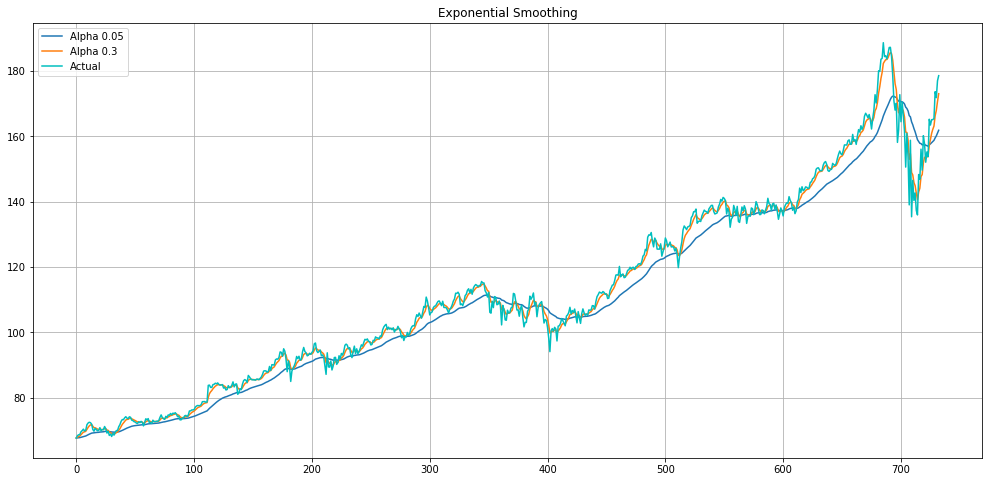

In [19]:
plot_exponential_smoothing(df.Close, [0.05, 0.3])

In [20]:
#Double exponential smoothing
def double_exponential_smoothing(series,alpha,beta):
    result = [series[0]]
    for n in range(1,len(series)+1):
        if n ==1 :
            level, trend = series[0], series[1] -series[0]
        
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [21]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

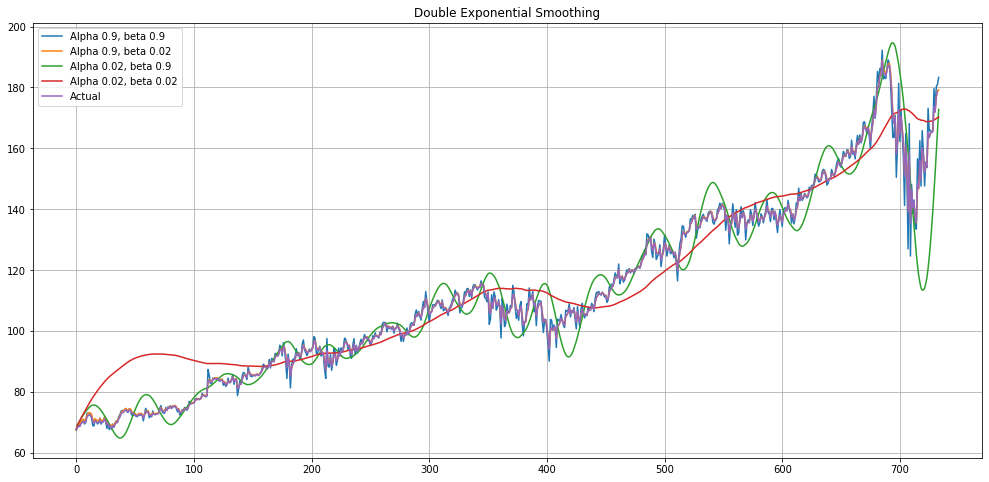

In [23]:
plot_double_exponential_smoothing(df.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

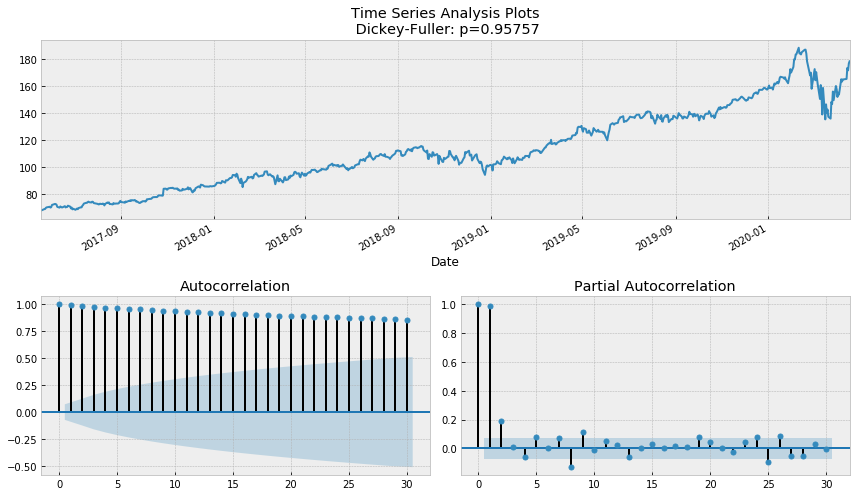

In [25]:
#Sationarity
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))  #auto correlation function
        pacf_ax = plt.subplot2grid(layout, (1,1)) #partial auto correlation function
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df.Close, lags=30)

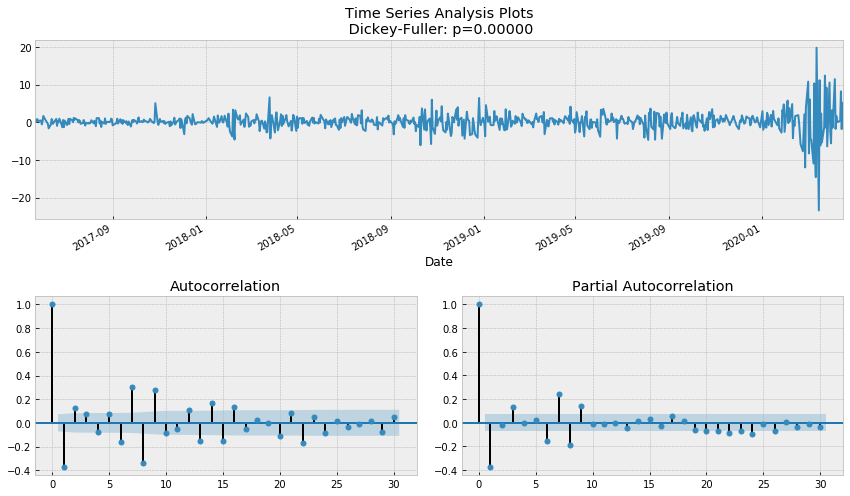

In [29]:
data_diff = df.Close - df.Close.shift(1)
tsplot(data_diff[1:], lags=30)

In [30]:
#SARIMA
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#create a list with all possible combinations of parameters
parameters = product(ps,qs,Ps,Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [33]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [34]:
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                  733
Model:             SARIMAX(4, 1, 4)x(1, 1, 1, 5)   Log Likelihood               -1605.545
Date:                           Sun, 19 Apr 2020   AIC                           3233.091
Time:                                   13:48:04   BIC                           3283.569
Sample:                                        0   HQIC                          3252.570
                                           - 733                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2622      0.062     -4.197      0.000      -0.385      -0.140
ar.L2          0.9153      0.060     15.239

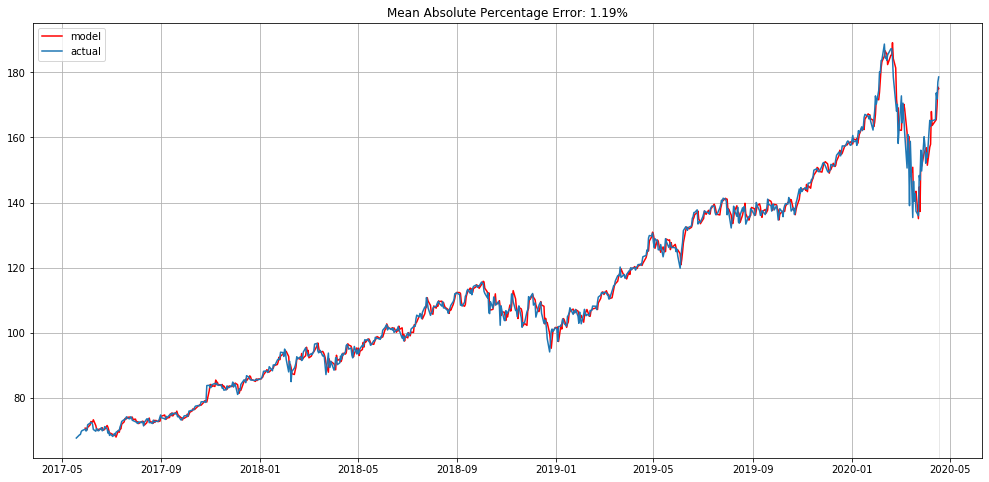

In [83]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'Close': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    data['arima_model'] = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {:.2f}%'.format(error))
    plt.plot(data.arima_model, color='r', label='model')
    plt.axvspan(data.index[-1], data.arima_model.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(series.Close, label='actual')
    plt.legend()
    plt.grid(True);
plot_SARIMA(df, best_model, 5)

In [82]:
print(best_model.predict(start=df.Close.shape[0], end=df.Close.shape[0] + 5))
print(mean_absolute_percentage_error(df.Close[s+d:], best_model.fittedvalues[s+d:]))

733    179.830207
734    179.045996
735    178.900045
736    180.201191
737    177.615157
738    179.682586
dtype: float64
1.1929182528378581
